# Computing Ionisation form factors for Xenon
now using the unbound wavefunctions computed for a hydrogren-like Schroedinger equation with $e^2 \rightarrow Z_{\rm eff}e^2$. Where $Z_{\rm eff}$ is to be decided (not 54) 

### We use the formula for the dimensionless ionisation form factor
\begin{equation}
\left|f_{n \ell \rightarrow p^{\prime}}^{\mathrm{ion}}(q)\right|^{2}=\frac{2 p^{\prime 3}}{(2 \pi)^{3}} \frac{1}{2 \ell+1} \sum_{\ell^{\prime} L}\left[\left(\begin{array}{ccc}{\ell} & {\ell^{\prime}} & {L} \\ {0} & {0} & {0}\end{array}\right)\right]^{2}(2 \ell+1)\left(2 \ell^{\prime}+1\right)(2 L+1) \, \,
\left|\int r^{2} d r R_{p^{\prime} \ell^{\prime}}^{*}(r) R_{n \ell}(r) j_{L}(q r)\right|^{2}
\end{equation}

With an extra factor of $2 \times (2\ell +1)$ put in for atoms with multiple electrons

In [ ]:
import sys
sys.path.append('../erec')
from numpy import *
from Params import *
from PlotFuncs import *
from AtomicFuncs import *
from HaloFuncs import *
from DMFuncs import *
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean


from sympy.physics.wigner import wigner_3j
from scipy.special import factorial,spherical_jn


# First we check we can reproduce Chris' Hydrogen plots.
This is a comparison of the ionisation form factor for hydrogen using an outgoing plane wave and using the expansion of the plane wave in terms of $j_L$

\begin{equation}
R_{p^{\prime} \ell^{\prime}}(r)=4 \pi i^{\ell^{\prime}} j_{\ell^{\prime}}\left(p^{\prime} r\right)
\end{equation}


## 1s

(0, 10)

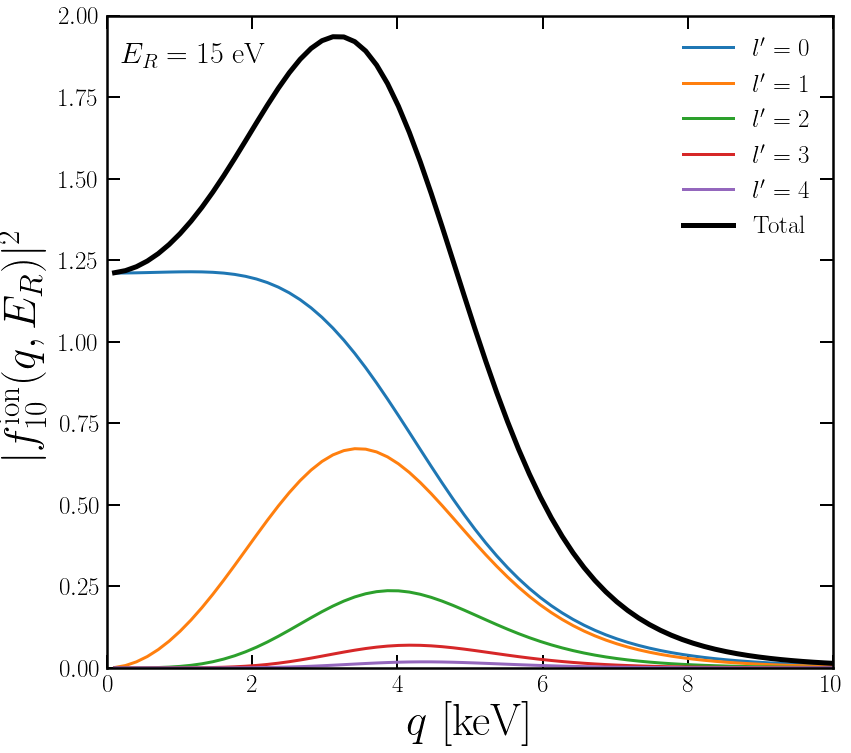

In [293]:
fig,ax = MySquarePlot('$q$ [keV]',r'$|f_{10}^{\rm ion}(q,E_R)|^2$')

r = logspace(-2,1,100)*a0
E_r = 15.0/1.0e3
ppr = sqrt(2*E_r*m_e)


# Hydrogen 1s
n = 1
l = 0
R10 = lambda r : 2*(a0)**(-3.0/2.0)*exp(-r/a0)
R_out_PW = lambda r,lp : 4*pi*spherical_jn(lp,ppr*r)

nq = 100
qvals = linspace(0.1,15.0,nq)
fion_pre = (2*ppr**3.0/(2*pi)**3.0)*(1.0/(2*l+1.0))
fion_PW = zeros(shape=nq)
fl = zeros(shape=nq)
for lp in [0,1,2,3,4]:
    for L in arange(abs(l-lp),l+lp+1,2):
        W = wigner_3j(l,lp,L,0,0,0)**2.0
        for i in range(0,nq):  
            Rint = trapz(r**2.0*R_out_PW(r,lp)*R10(r)*spherical_jn(L,qvals[i]*r),r)**2.0
            fl[i] = fion_pre*W*(2*l+1)*(2*lp+1)*(2*L+1)*Rint
        fion_PW += fl
        plt.plot(qvals,fl,'-',lw=3,label="$l'$ = "+str(lp))



plt.gcf().text(0.14,0.82,r'$E_R = 15$ eV',fontsize=30)
plt.plot(qvals,fion_PW,'k-',lw=5,label='Total')

plt.legend(frameon=False)
plt.ylim([0,2])
plt.xlim([0,10])

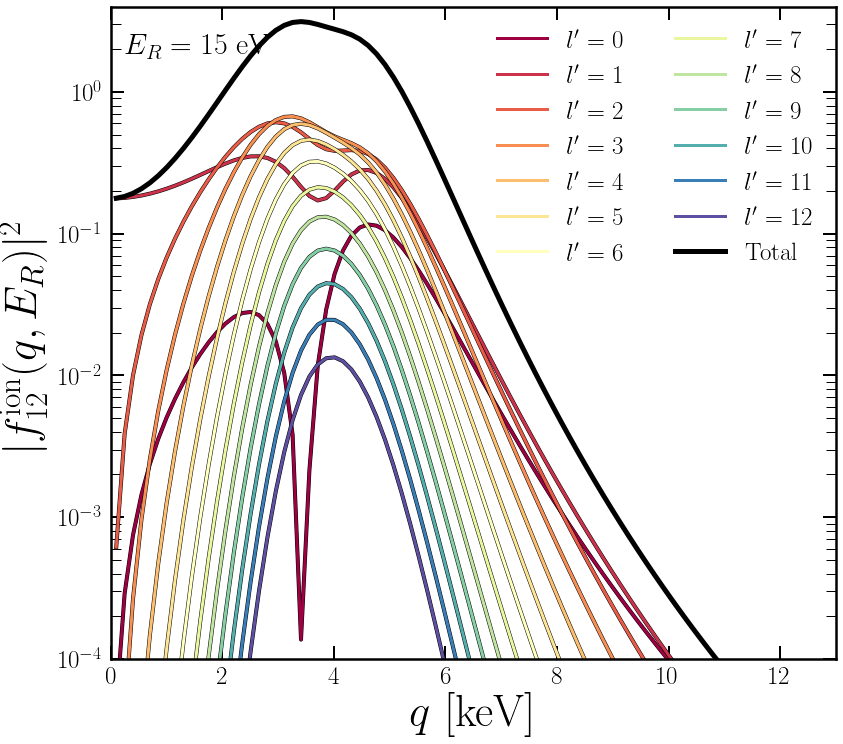

In [297]:
fig,ax =  MySquarePlot('$q$ [keV]',r'$|f_{12}^{\rm ion}(q,E_R)|^2$')

r = logspace(-1,3,1000)*a0

n = 2
l = 1
R21 = lambda r : 1.0/(2*sqrt(6)*(a0)**(3.0/2.0))*(r/a0)*exp(-r/(2*a0))

lpmax = 12
lpvals = arange(0,lpmax+1)
cols = cm.Spectral(linspace(0,1,lpmax+1))

fion = zeros(shape=nq)


fion_pre = (2*ppr**3.0/(2*pi)**3.0)*(1.0/(2*l+1.0))
for lp in lpvals:
    fl = zeros(shape=nq)
    for L in arange(abs(l-lp),l+lp+1,2):
        W = wigner_3j(l,lp,L,0,0,0)**2.0
        for i in range(0,nq):  
            Rint = trapz(r**2.0*R_out_PW(r,lp)*R21(r)*spherical_jn(L,qvals[i]*r),r)**2.0
            fl[i] += fion_pre*W*(2*l+1)*(2*lp+1)*(2*L+1)*Rint
    fion += fl
    plt.plot(qvals,fl,'-',lw=4,color='k')
    plt.plot(qvals,fl,'-',lw=3,color=cols[lp,:],label="$l'$ = "+str(lp))

plt.plot(qvals,fion,'k-',lw=5,label='Total')

plt.gcf().text(0.14,0.82,r'$E_R = 15$ eV',fontsize=30)
plt.legend(frameon=False,ncol=2)

plt.ylim([1e-4,4])
plt.xlim([0,13])
plt.yscale('log')

# Now we can implement the unbound wavefunctions which have solutions:

\begin{equation}
R_{p^\prime \ell^\prime}(r)=\frac{4 \pi}{2 p^\prime r} \frac{\left|\Gamma\left(\ell^\prime+1-\frac{i Z_{\rm eff}}{k}\right)\right| e^{\frac{\pi Z_{\rm eff}}{2 p^\prime}}}{(2 \ell^\prime+1) !} \cdot(2 p^\prime r)^{\ell^\prime+1} \cdot e^{-i p^\prime r} \cdot M\left(\ell^\prime+1+\frac{i Z_{\rm eff}}{p^\prime}, 2 \ell^\prime+2 ; 2 i p^\prime r\right)
\end{equation}

In atomic units

Currently we have to do some ugly things to compute this. Might be a cleaner way to deal with the complex input to Kummer's confluent hypergeometric function, but will need to learn how this behaves. Fortunately the bound wavefunctions are real so for now we can just compute the real and imaginary parts of the unbound solution and then use them separately in the form factor.

Use mpmath so that we have access to mp.hyp1f1 which will accept complex valued arguments. scipy.special's implementation only accepts real valued arguments, if there is a way to manipulate the formula somehow that would likely speed up the calculation. But as it is, it's not too bad since we only need to tabulate the function $R_{p^\prime \ell^\prime}$ for each $\ell

In [298]:

import mpmath as mp
mp.pretty = False

def R_Unbound(r_keV,ppr_keV,l,Z=1):
    n = size(r_keV)
    r = r_keV/a0
    k = ppr_keV*a0

    Rf = (4*pi/(2*k))*abs(mp.gamma(l+1-mp.j*Z/k))*exp(pi*Z/(2*k))/factorial(2*l+1)

    Rreal = zeros(shape=n)
    Rimag = zeros(shape=n)
    for ii in range(0,n):
        R1 = Rf*(2*k*r[ii])**(l+1)*mp.exp(-mp.j*k*r[ii])*mp.hyp1f1(l+1+mp.j*Z/k,2*l+2,2*mp.j*k*r[ii])/r[ii]
        Rreal[ii] = R1.real
        Rimag[ii] = R1.imag
    return Rreal,Rimag

# Now calculate the ionisation form factors for $Z_{\rm eff} = 54$ and $Z_{\rm eff} = 28$

We plot each component of $\ell^\prime$ summation in reverse order.

We take the case of Xe 3$s$ and a recoil energy of $E_r = 2$ keV to compare with the Roberts and Flambaum paper.

(0.029999999999999995, 4.0)

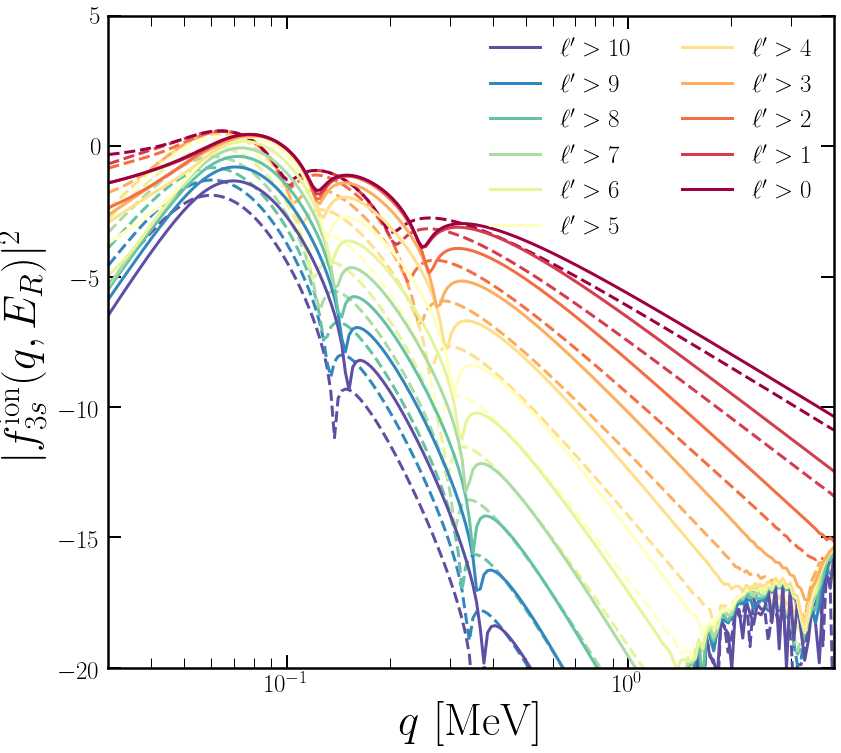

In [317]:
r = logspace(-4,3,10000)*a0
E_r = 2.0
ppr = sqrt(2*E_r*m_e)
nq = 200
qvals = logspace(log10(0.03),log10(4.0),nq)*1000.0


n = 3
l = 0
n_s = array([1]+[2]*2+[3]*3+[4]*3+[5]*4)
Z_s = array([54.9179,47.2500,26.0942,68.1771,16.8296,12.0759,31.9030,8.0145,5.8396,14.7123,3.8555,2.6343,1.8124])
c_3s = array([-0.140382,-0.125401,0.528161,-0.000435,0.494492,-1.855445,0.128637,-0.017980,0.000792,0.333907,-0.000228,0.000191,-0.000037])
R_3s = R_nl(r,c_3s,n_s,Z_s)
        
fig,ax = MySquarePlot('$q$ [MeV]',r'$|f_{3s}^{\rm ion}(q,E_R)|^2$')

Z = 28
fion_pre = (2*ppr**3.0/(2*pi)**3.0)*(1.0/(2*l+1.0))*2*(2*l+1)
fion28 = zeros(shape=nq)
for lp in flipud(lpvals):
    fl = zeros(shape=nq)
    Rreal,Rimag = R_Unbound(r,ppr,lp,Z)
    for L in arange(abs(l-lp),l+lp+1,2):
        W = wigner_3j(l,lp,L,0,0,0)**2.0
        for i in range(0,nq):  
            Rint = trapz(r**2.0*R_3s*Rreal*spherical_jn(L,qvals[i]*r),r)**2.0 \
                         + trapz(r**2.0*R_3s*Rimag*spherical_jn(L,qvals[i]*r),r)**2.0
            fl[i] += fion_pre*W*(2*l+1)*(2*lp+1)*(2*L+1)*Rint
    fion28 += fl
    plt.plot(qvals/1000,log10(fion28),'--',lw=3,color=cols[lp,:])


Z = 54
fion_pre = (2*ppr**3.0/(2*pi)**3.0)*(1.0/(2*l+1.0))*2*(2*l+1)
fion54 = zeros(shape=nq)
for lp in flipud(lpvals):
    fl = zeros(shape=nq)
    Rreal,Rimag = R_Unbound(r,ppr,lp,Z)
    for L in arange(abs(l-lp),l+lp+1,2):
        W = wigner_3j(l,lp,L,0,0,0)**2.0
        for i in range(0,nq):  
            Rint = trapz(r**2.0*R_3s*Rreal*spherical_jn(L,qvals[i]*r),r)**2.0 \
                         + trapz(r**2.0*R_3s*Rimag*spherical_jn(L,qvals[i]*r),r)**2.0
            fl[i] += fion_pre*W*(2*l+1)*(2*lp+1)*(2*L+1)*Rint
    fion54 += fl
    plt.plot(qvals/1000,log10(fion54),'-',lw=3,color=cols[lp,:],label=r'$\ell^\prime > '+str(lp)+r' $')

plt.legend(frameon=False,ncol=2)
plt.xscale('log')
plt.ylim([-20,5])
plt.xlim([qvals[0]/1000,qvals[-1]/1000])

## We see a few precision issues for highest $q$ and high $\ell^\prime$. These can be rectified by decreasing the grid spacing for the $r$ integration.

# Now we plot the sums of those terms together to compare.

(0.029999999999999995, 4.0)

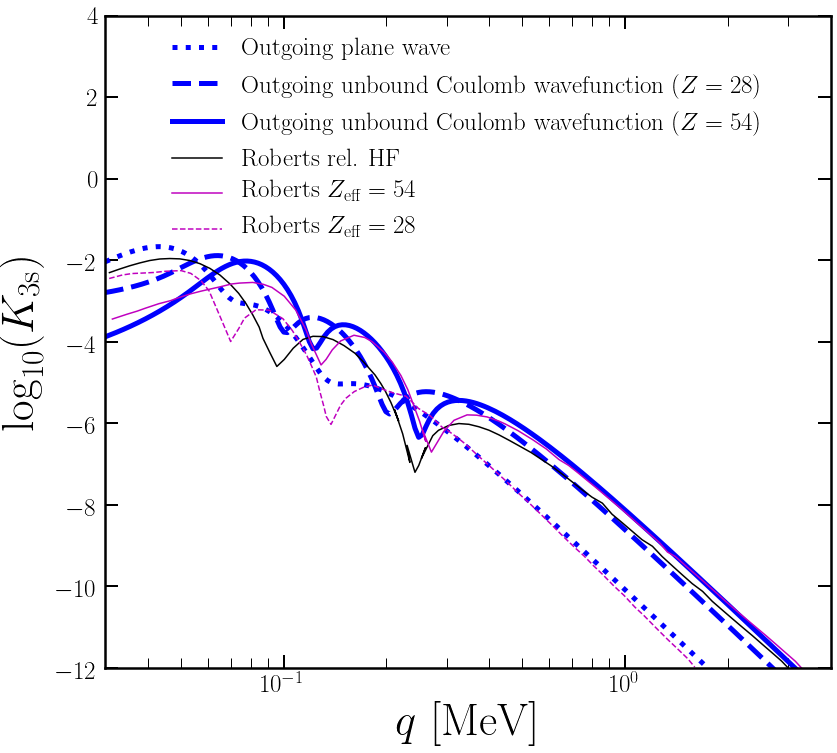

In [325]:
fig,ax = MySquarePlot('$q$ [MeV]',r'$\log_{\rm 10}(K_{\rm 3s})$')
fion_prev = f_nl_ion_sq(qvals,E_r,0,c_3s,n_s,Z_s,np=5000) # Plane wave ionisation form factor

Factor = (alph/a0)/(4*E_r) # Translate between ionisation form factor and atomic ionisation kernel

plt.plot(qvals/1000,log10(fion_prev*Factor),'b:',lw=5,label='Outgoing plane wave')
plt.plot(qvals/1000,log10(fion28*Factor),'b--',lw=5,label='Outgoing unbound Coulomb wavefunction ($Z=28$)')
plt.plot(qvals/1000,log10(fion54*Factor),'b-',lw=5,label='Outgoing unbound Coulomb wavefunction ($Z=54$)')

dat = loadtxt('../data/fion/K_Xe3s_Roberts_relHF.txt',delimiter=',')
plt.plot(dat[:,0],dat[:,1],'k-',label=r'Roberts rel. HF')

dat = loadtxt('../data/fion/K_Xe3s_Roberts_Z54.txt',delimiter=',')
plt.plot(dat[:,0],dat[:,1],'m-',label=r'Roberts $Z_{\rm eff} = 54$')

dat = loadtxt('../data/fion/K_Xe3s_Roberts_Z28.txt',delimiter=',')
plt.plot(dat[:,0],dat[:,1],'m--',label=r'Roberts $Z_{\rm eff} = 28$')


plt.legend(loc='upper center',frameon=False)

plt.xscale('log')
plt.ylim([-12,4])
plt.xlim([qvals[0]/1000,qvals[-1]/1000])

# So none of these really match at this point. And I'm not sure if you would expect them too. I don't exactly what approximation Roberts and Flambaum have used to calculate their non-HF lines. 

## some observations
* Roberts' Zeff = 28 and our outgoing plane wave approx. seem to agree on the locations of the minima and the high$q$-scaling. But the low $q$ scaling and the behaviour around the minima do not agree. Since these both use an outgoing plane wave the difference must be in the bound wavefunctions. I'm unclear how to modify the Bunge et al. RHF Xenon wavefunctions to account for an effective nuclear charge, but there may be a Fermi fudge factor or something like that one can put in.
* The coulomb wavefunctions seem to systematically underestimate the low-$q$ scaling and decay too fast below the peak compared with all of Roberts' methods.  
* The coulomb wavefunctions also look like they roughly produce the correct behaviour for high-$q$.

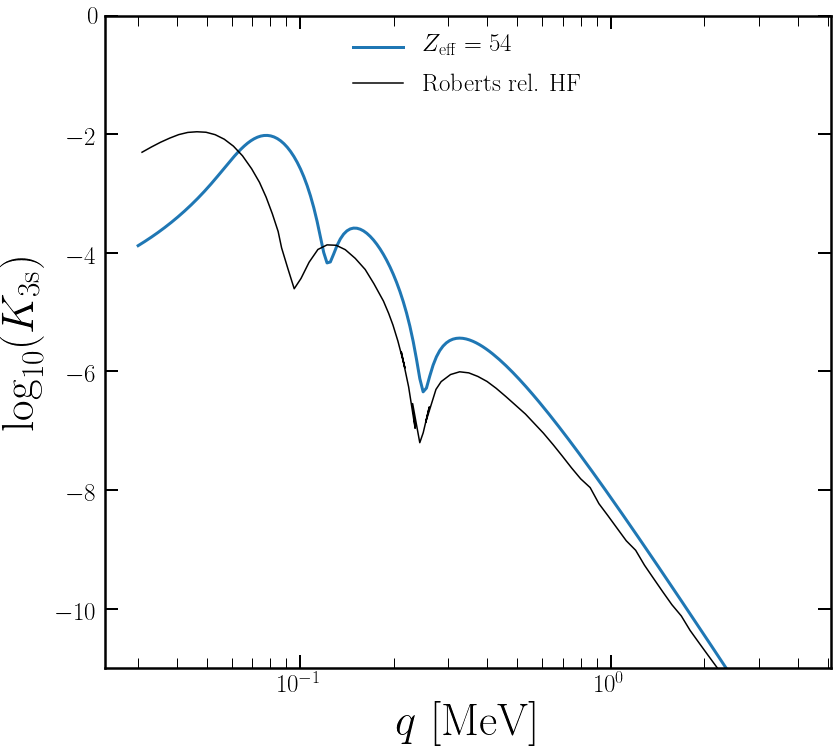

In [321]:
fig,ax = MySquarePlot('$q$ [MeV]',r'$\log_{\rm 10}(K_{\rm 3s})$')

def K3sZ(Z):
    fion = zeros(shape=nq)
    for lp in flipud(lpvals):
        fl = zeros(shape=nq)
        Rreal,Rimag = R_Unbound(r,ppr,lp,Z)
        for L in arange(abs(l-lp),l+lp+1,2):
            W = wigner_3j(l,lp,L,0,0,0)**2.0
            for i in range(0,nq):  
                Rint = trapz(r**2.0*R_3s*Rreal*spherical_jn(L,qvals[i]*r),r)**2.0 \
                             + trapz(r**2.0*R_3s*Rimag*spherical_jn(L,qvals[i]*r),r)**2.0
                fl[i] += fion_pre*W*(2*l+1)*(2*lp+1)*(2*L+1)*Rint
        fion += fl
    return fion

[plt.plot(qvals/1000,log10(K3sZ(Z)*Factor),'-',lw=3,label=r'$Z_{\rm eff}$ = '+str(Z)) for Z in [28,54]]


dat = loadtxt('../data/fion/K_Xe3s_Roberts_relHF.txt',delimiter=',')
plt.plot(dat[:,0],dat[:,1],'k-',label=r'Roberts rel. HF')


plt.legend(loc='upper center',frameon=False)
plt.ylim([-11,0])
plt.xscale('log')

10.565523171743001


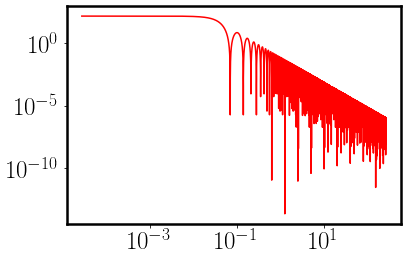

In [336]:
Rreal,Rimag = R_Unbound(r,ppr,0,0)

Rsq = Rreal**2.0+Rimag**2.0

plt.loglog(r,Rsq,'r-')
print(trapz(Rsq*r**2.0,r))


38.62862410542108


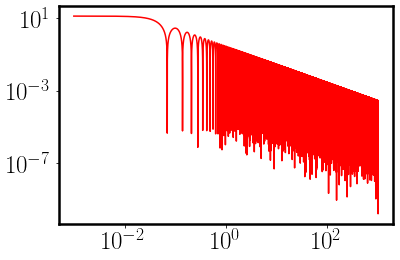

In [398]:
x = logspace(-3,3,10000000)
Rsq = (4*pi*spherical_jn(0,x*ppr))**2.0
plt.loglog(x,sqrt(Rsq),'r-')
print(trapz(Rsq*x**2.0,x))

In [381]:
(2*pi)**3.0/ppr**2.0

0.12135529033385448

In [355]:
E_r

2.0